In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [3]:
def get_drives(team_df, label):
    """
    This function will segment the play by play into offensive drive segments
    """
    result = []
    to_add = []
    for index, row in team_df.iterrows():
        if row.posteam != label and len(to_add) > 2 and row.quarter_end != 1:
            result.append(pd.concat(to_add, axis = 1).T)
            to_add = []
        elif (row.posteam == label and row.play_type != "kickoff"):
            to_add.append(row)
    return result

def convert_ydstogo_in_5_increments(ytg):
    """
    A helper function to convert yds to go into a bin label
    """
    if ytg <= 5:
        return "0"
    elif ytg > 5 and ytg <= 10:
        return "1"
    elif ytg > 10:
        return "2"


def get_prob_matrices(drives):
    """
    Create probabilitiy matrices necessary for the simulation
    """
    prob_trans_matrix = defaultdict(lambda: defaultdict(int))
    prob_init_matrix = defaultdict(int)
    extra_point_matrix = defaultdict(int)
    state_template = "{down}_{ydstogo}_{yardbin}"
    for df in drives:
        prev_state = ""
        for index, row in df.reset_index().iterrows():
            if str(row.down) == "nan":
                continue
            current_state = state_template.format(down=int(row.down), ydstogo=convert_ydstogo_in_5_increments(row.ydstogo), 
                                        yardbin=int(np.around(row.yardline_100/10)))
            if index == 0:
                # init state for a drive
                if int(row.down) == 1:
                    prob_init_matrix[current_state] += 1
            else:
                # check if current state is end state
                # touch
                if row.touchdown == 1:
                    prob_trans_matrix[prev_state]["touchdown"] += 1
                    # check for extra_point or 2 point attempts
                    if "extra_point" in str(df.tail(1).play_type):
                        if "no good" in str(df.tail(1).desc).lower():
                            extra_point_matrix["extra_point_fail"] += 1
                        else:
                            extra_point_matrix["extra_point_success"] += 1
                    elif "two-point" in str(df.tail(1).desc).lower():
                        if "succeeds" in str(df.tail(1).desc).lower():
                            extra_point_matrix["two_point_success"] += 1
                        else:
                            extra_point_matrix["two_point_fail"] += 1
                # field goal attempt
                elif row.field_goal_attempt == 1:
                    if "no good" in str(row.desc).lower():
                        prob_trans_matrix[prev_state]["fg_fail"] += 1
                    else:
                        prob_trans_matrix[prev_state]["fg_sucess"] += 1
                # safety
                elif row.safety == 1:
                    prob_trans_matrix[prev_state]["safety"] += 1
                # interception
                elif row.interception == 1:
                    prob_trans_matrix[prev_state]["interception"] += 1
                # fumble
                elif row.fumble == 1:
                    prob_trans_matrix[prev_state]["fumble"] += 1
                # fourth_down_fail
                elif row.fourth_down_failed == 1:
                    prob_trans_matrix[prev_state]["fourth_down_failed"] += 1
                # punt
                elif row.punt_attempt == 1:
                    prob_trans_matrix[prev_state]["punt"] += 1

                # record transition states
                prob_trans_matrix[prev_state][current_state] += 1
            # update prev_state
            prev_state = current_state
    ptm_df = pd.DataFrame.from_dict(prob_trans_matrix).fillna(0)
    ptm_df = ptm_df/ptm_df.sum(axis=0)
    pim_df = pd.DataFrame.from_dict(prob_init_matrix, "index").T
    pim_df = pim_df.divide(pim_df.sum(axis=1), axis=0)
    epm_df = pd.DataFrame.from_dict(extra_point_matrix, "index").T
    epm_df = epm_df.divide(epm_df.sum(axis=1), axis=0)
    return [ptm_df, pim_df, epm_df]

def simulate_random_walk(df, ptm, pim, epm):
    """
    Randomly walk through the probability matrices, tallying up the game score
    """
    grouped_df = df.groupby(by="game_id").size()
    expected_steps = int(np.around(np.random.normal(grouped_df.mean(), grouped_df.std())))
    total_score = 0
    init_step = True
    current_state = ""
    for steps in range(expected_steps):
        if init_step:
            while True:
                current_state = np.random.choice(list(pim), 1, p=pim.iloc[0,:])[0]
                if len(ptm.get(current_state)) > 0:
                    init_step = False
                    break
        else:
            possible_states = ptm.get(current_state)
            if possible_states is None:
                init_step = True
                continue
            else:
                next_state = np.random.choice(list(possible_states.index), 1, p=list(possible_states))[0]
                if next_state == "safety":
                    total_score += 2
                    init_state = True
                elif next_state == "fg_sucess":
                    total_score += 3
                    init_step = True
                elif next_state == "touchdown":
                    total_score += 6
                    ep_att = np.random.choice(list(epm), 1, p=epm.iloc[0,:])[0]
                    if ep_att == "extra_point_success":
                        total_score += 1
                    elif ep_att == "two_point_sucess":
                        total_score += 2
                    init_step = True
                elif next_state in ["fg_fail", "fourth_down_failed", "fumble", "interception", "punt"]:
                    init_step = True
                else:
                    current_state = next_state
    return total_score

def run_simulation_ntimes(ntimes, team1_data, team1_matrices, team1_label, team2_data, team2_matrices, team2_label):
    """
    Run the simulation n times, and returns a dataframe with respective scores and winner
    """
    results = []
    for n in range(ntimes):
        team1_score = simulate_random_walk(team1_data[team1_data.posteam == team1_label], 
                                            team1_matrices[0], team1_matrices[1], team1_matrices[2])
        team2_score = simulate_random_walk(team2_data[team2_data.posteam == team2_label], 
                                            team2_matrices[0], team2_matrices[1], team2_matrices[2])
        if team1_score == team2_score:
            # edge case ignore
            continue
        to_add = {"team1_score": team1_score, "team2_score": team2_score}
        if team1_score > team2_score:
            to_add["winner"] = team1_label
        else:
            to_add["winner"] = team2_label
        results.append(to_add)
    return results

In [4]:
## Read in the play by play data files
cols = ["home_team", "away_team", "game_id", "posteam", "yardline_100", "down", "ydstogo", "desc", "play_type", "qtr", "quarter_end", 
        "score_differential", "touchdown", "interception", "fumble", "field_goal_attempt", "safety", "fourth_down_failed", 
        "punt_attempt"]
fn_template = "reg_pbp_{}.csv"
pbp = pd.read_csv(fn_template.format(2009), low_memory=False, usecols=cols)
for season_type in ["reg", "post"]:
    for year in range(2010, 2019):
        filename = "{}_pbp_{}.csv".format(season_type, year)
        pbp = pd.merge(pbp, pd.read_csv(filename, low_memory=False, usecols=cols), how="outer")

In [5]:
### Separate data into according teams
LA_data = pbp[((pbp.home_team == "LA") | (pbp.away_team == "LA")) & 
              (pbp.desc.str.contains("Two-Minute Warning") == False) & (pbp.play_type != "no_play")]
NE_data = pbp[((pbp.home_team == "NE") | (pbp.away_team == "NE")) & 
              (pbp.desc.str.contains("Two-Minute Warning") == False) & (pbp.play_type != "no_play")]

In [6]:
### Get offensive drive segments and its probability matrices for respective teams
LA_drives = get_drives(LA_data, "LA")
NE_drives = get_drives(NE_data, "NE")
LA_prob_matrices = get_prob_matrices(LA_drives)
NE_prob_matrices = get_prob_matrices(NE_drives)

In [9]:
### Simulation time!
sim_results_10000 = run_simulation_ntimes(10000, NE_data, NE_prob_matrices, "NE", LA_data, LA_prob_matrices, "LA")
sim_df_10000 = pd.DataFrame(sim_results_10000)
sim_df_10000.to_csv("sim_results_10000.csv", index=False)

In [10]:
from matplotlib import pyplot as plt    
import seaborn as sns

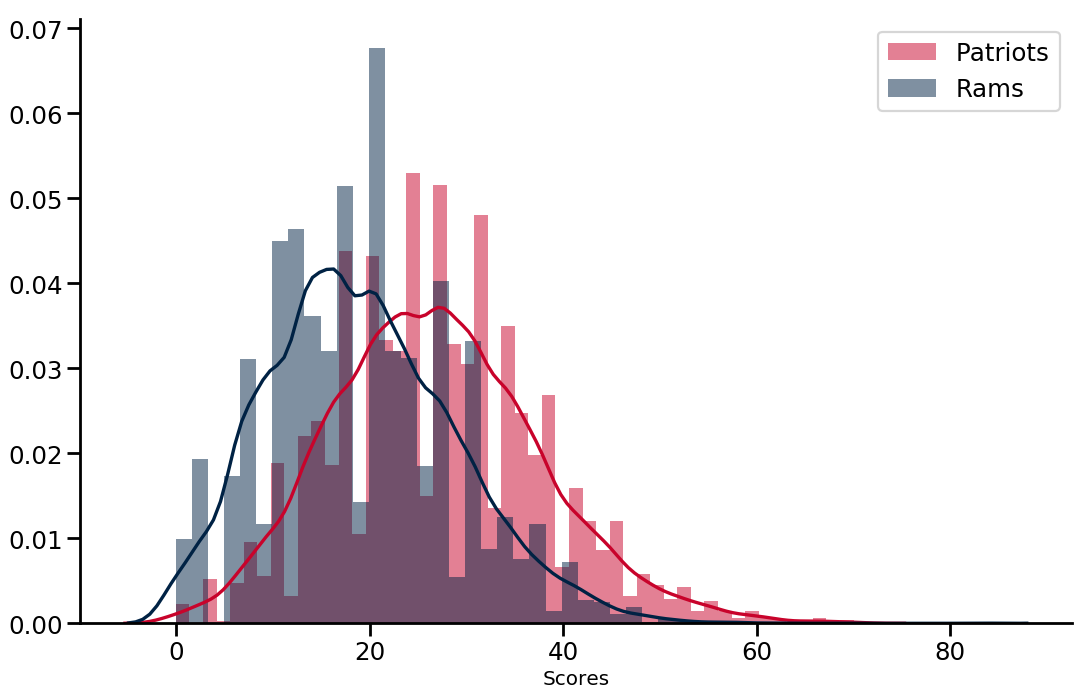

In [42]:
### Plot the histogram and kde plot for each team's final scores
fig3 = plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(sim_df_10000.team1_score, color = "#C8032B", label = "Patriots", hist_kws={'alpha':.5}, kde_kws={'linewidth':3})
sns.distplot(sim_df_10000.team2_score, color = "#002244", label = "Rams", hist_kws={'alpha':.5}, kde_kws={'linewidth':3})
sns.despine()
sns.set_context("poster")
plt.legend()
plt.xlabel("Scores", fontsize=18)
plt.show()

In [43]:
fig3.savefig("sim_10000_kde.png", transparent=True)

In [44]:
print(f"Mean: {np.mean(sim_df_10000.team1_score)} STD: {np.std(sim_df_10000.team1_score)}")

Mean: 26.830053852526927 STD: 10.738783470190425


In [45]:
print(f"Mean: {np.mean(sim_df_10000.team2_score)} STD: {np.std(sim_df_10000.team2_score)}")

Mean: 19.14923363711682 STD: 9.655756437845998


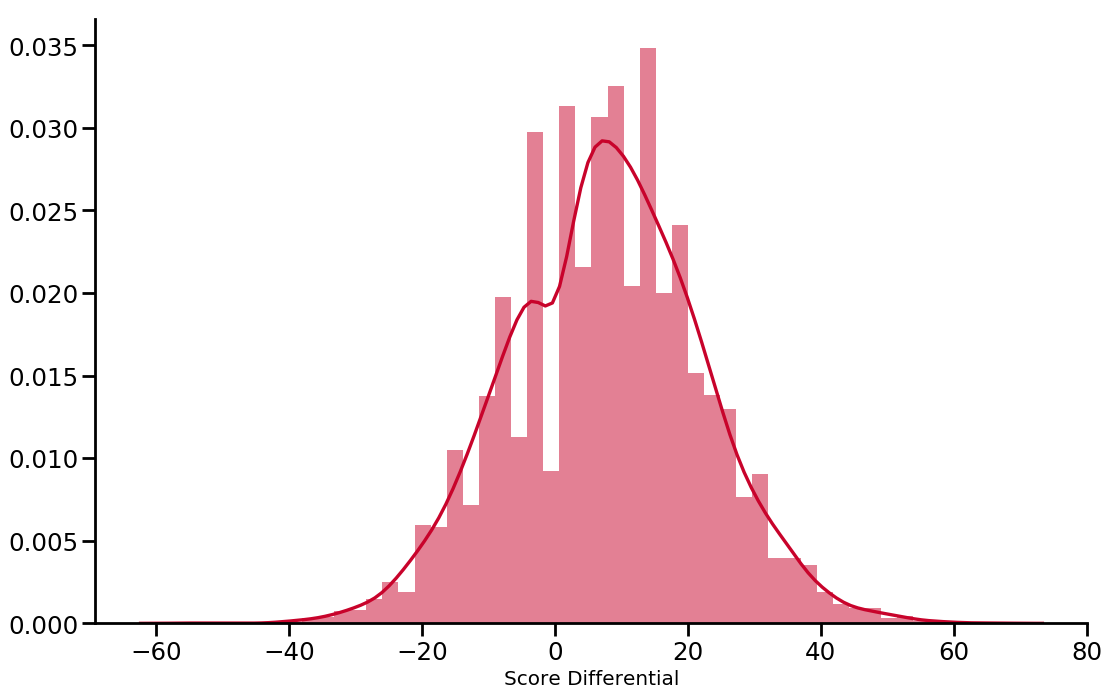

In [46]:
### Plot the histogram and kde plot for the score differential
fig4 = plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(sim_df_10000.team1_score - sim_df_10000.team2_score, color = "#C8032B", hist_kws={'alpha':.5}, kde_kws={'linewidth':3})
sns.despine()
sns.set_context("poster")
plt.xlabel("Score Differential", fontsize=18)
plt.show()

In [48]:
fig4.savefig("diff_kde.png", transparent=True)

In [49]:
print(f"Mean: {np.mean(sim_df_10000.team1_score - sim_df_10000.team2_score)} STD: {np.std(sim_df_10000.team1_score - sim_df_10000.team2_score)}")

Mean: 7.680820215410107 STD: 14.464797023505842
